In [8]:
import os
os.environ['MKL_NUM_THREADS'] = "32"
os.environ["THEANO_FLAGS"] = "device=cpu,floatX=float64,dnn.enabled=True"

In [9]:

import theano

import gempy as gp


In [10]:
import rasterio as rio
from rasterio.warp import transform
import rasterio.warp
from pathlib import Path
import pyvista as pv
# Embedding matplotlib figures in the notebooks|
# Importing auxiliary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas 
import qgrid
from shapely.geometry import box
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = [20,20]
%matplotlib inline

In [11]:
theano.config.floatX 

'float64'

In [12]:
# try a subset instead
sera = '/home/andrew/Dropbox/Planetary/Dems/Arabia/crater_a/MGM_DEM/sera_mgm_filled_16m.tif'

In [13]:
with rio.open(sera) as sera_rio:
    b = sera_rio.bounds
    crs = sera_rio.crs

In [14]:
b

BoundingBox(left=-3351.5, bottom=515247.5, right=3496.5, top=529903.5)

# Create Model

In [15]:
section_dict = {
    'section1': ([-2000, 519250], [0, 519250], [200, 150]),
    'section2': ([-1600, 519250], [-1000, 519250], [200, 150]),
    'section3': ([-731.586, 518193.369], [-110.458, 518559.508], [200, 150]),
    'section4': ([-376.889, 517948.187], [-121.899, 518474.512], [250, 200]),
    'section5': ([2007.918, 519062.949], [2307.041, 519757.633], [250, 200]),
}

/home/andrew/anaconda3/envs/gempy3/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Active grids: ['regular']
Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
obacht
Active grids: ['regular' 'topography']


,start,stop,resolution,dist
section1,"[-2000, 519250]","[0, 519250]","[200, 150]",2000.000000
section2,"[-1600, 519250]","[-1000, 519250]","[200, 150]",600.000000
section3,"[-731.586, 518193.369]","[-110.458, 518559.508]","[200, 150]",721.011622
section4,"[-376.889, 517948.187]","[-121.899, 518474.512]","[250, 200]",584.840069
section5,"[2007.918, 519062.949]","[2307.041, 519757.633]","[250, 200]",756.346765


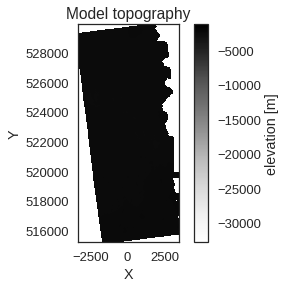

In [16]:
geo_model = gp.create_model('sera_crater_model_cpu_eros_dec31')
#theano.config.floatX = 'float64'
gp.init_data(geo_model, [-3351.5, 3496.5, 515247.5, 529903.5, -2580, -2280], [50,50,100],
             path_i = './sera_dense_reb/sera_points.csv',
             path_o ='./sera_dense_reb/sera_orientations.csv')
# first run only
geo_model.set_topography(source='gdal',filepath=sera)
geo_model.grid.set_section_grid(section_dict)

In [17]:
correct_order = geo_model.surfaces.df['order_surfaces']

In [18]:
geo_model.additional_data

values
Structure isLith                                                                    True
          isFault                                                                  False
          number faults                                                                0
          number surfaces                                                             27
          number series                                                                2
          number surfaces per series                                             [27, 0]
          len surfaces surface_points  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 5...
          len series surface_points                                            [1350, 0]
          len series orientations                                               [231, 0]
Options   dtype                                                                  float64
          output                                                                 geology
          theano_optimizer                                                  fast_compile
          device                                                                     cpu
          verbosity                                                                   []
Kriging   range                                                                  16179.7
          $C_o$                                                              6.23294e+06
          drift equations                                                         [3, 0]
          nugget grad                                                               0.01
          nugget scalar                                                            1e-06
Rescaling rescaling factor                                                       9932.04
          centers                      [311.58532926104317, 519063.9191177216, -2428....

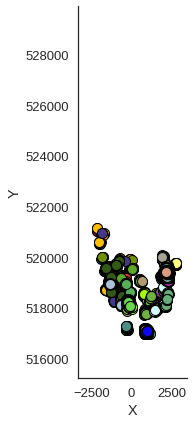

In [19]:
gp.plot.plot_data(geo_model, direction='z');

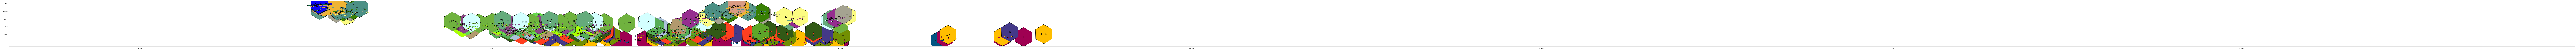

In [20]:
gp.plot.plot_data(geo_model, direction='x');

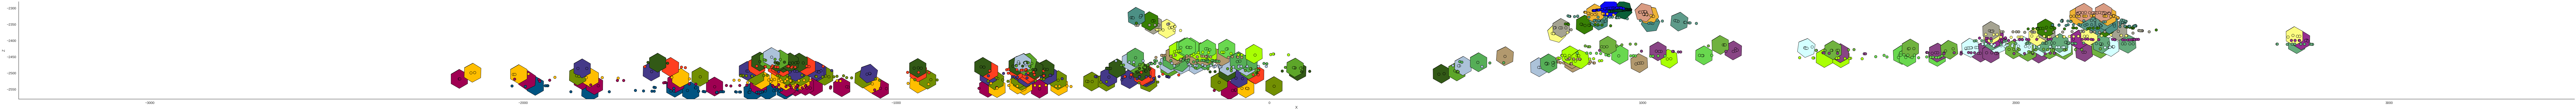

In [21]:
gp.plot.plot_data(geo_model, direction='y');

# Compute Model

In [22]:
gp.set_interpolation_data(geo_model, output='geology', dtype='float64',
                          compile_theano=True, theano_optimizer='fast_run')

Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [23]:
# # modifying kriging has to occur before model computation, but not be setting interpolation data
# geo_model.modify_kriging_parameters('drift equations', np.array([3,0]))
# geo_model.modify_kriging_parameters('nugget grad', 0.000001)
#geo_model.modify_kriging_parameters('nugget scalar', 0.0)
geo_model.modify_kriging_parameters('$C_o$', 1e-2)
geo_model.interpolator.set_initial_results()
geo_model.rescaling.set_rescaled_orientations()
geo_model.additional_data.kriging_data

,values
range,16179.7
$C_o$,0.01
drift equations,"[3, 0]"
nugget grad,0.01
nugget scalar,1e-06


In [24]:
lith = gp.compute_model(geo_model, compute_mesh=True, sort_surfaces=False, reset_weights=True, reset_scalar=True, reset_block=True)
lith

/home/andrew/Projects/gempy/gempy/core/solution.py:260: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')



Lithology ids 
  [28.         28.         28.         ...  5.          4.99748681
  4.        ] 

# Plot in 3d

/home/andrew/Projects/gempy/gempy/plot/visualization_2d.py:208: UserWarning: the orientations are not converted to apparent dip.
  warnings.warn('the orientations are not converted to apparent dip.')


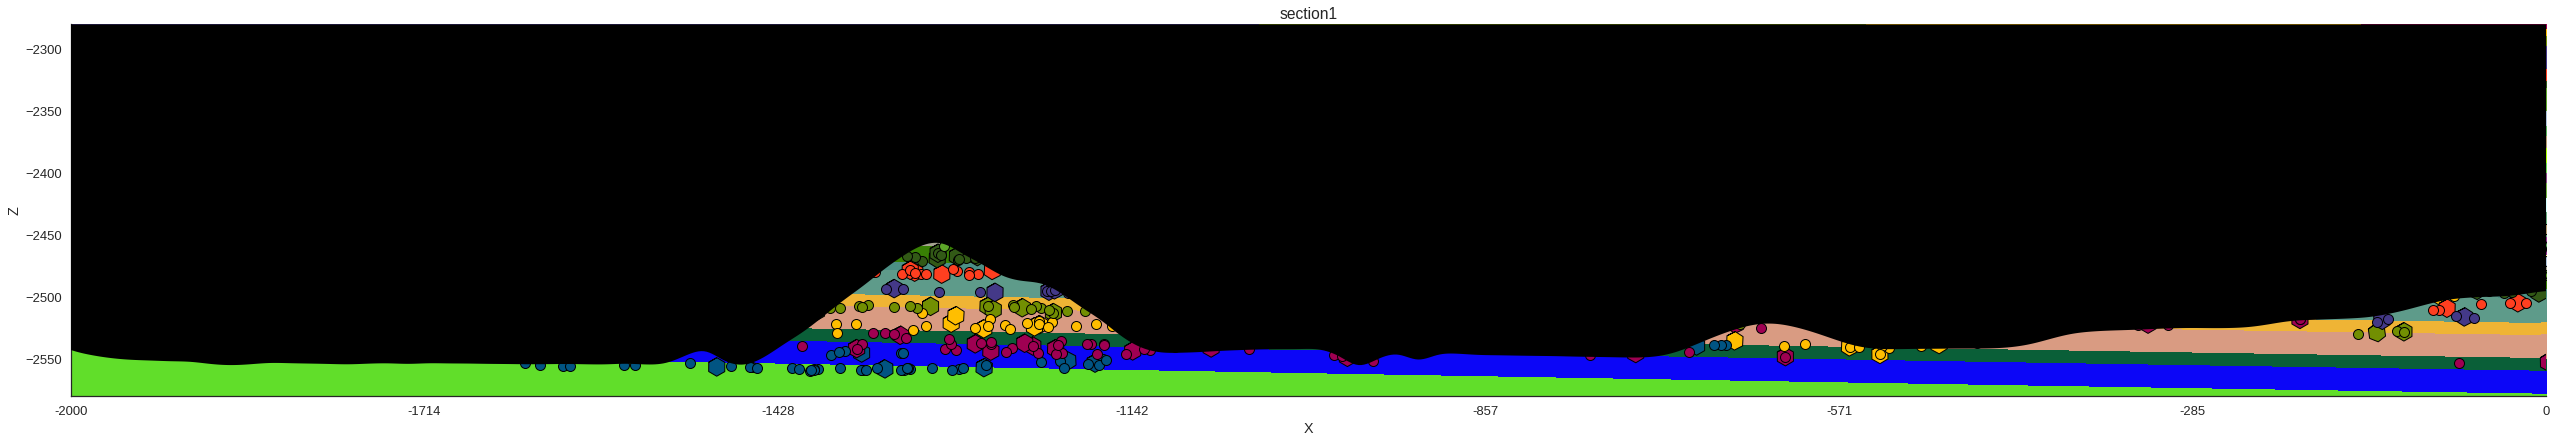

In [25]:
gp.plot.plot_section_by_name(geo_model, 'section1', show_topo=True, show_all_data=True)

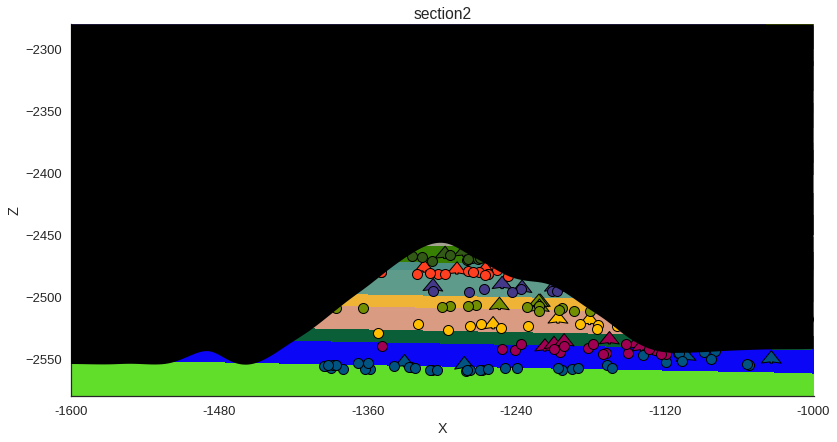

In [26]:
gp.plot.plot_section_by_name(geo_model, 'section2', show_topo=True, show_all_data=True)

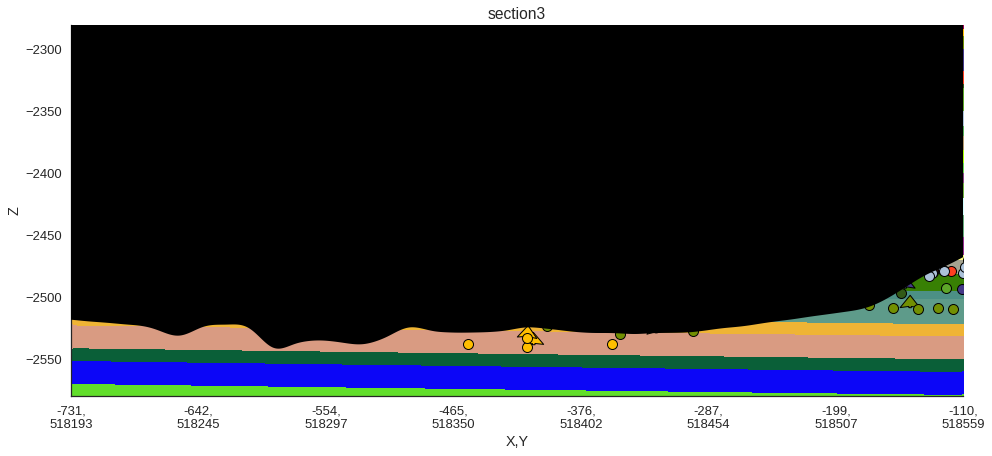

In [27]:
gp.plot.plot_section_by_name(geo_model, 'section3', show_topo=True, show_all_data=True)

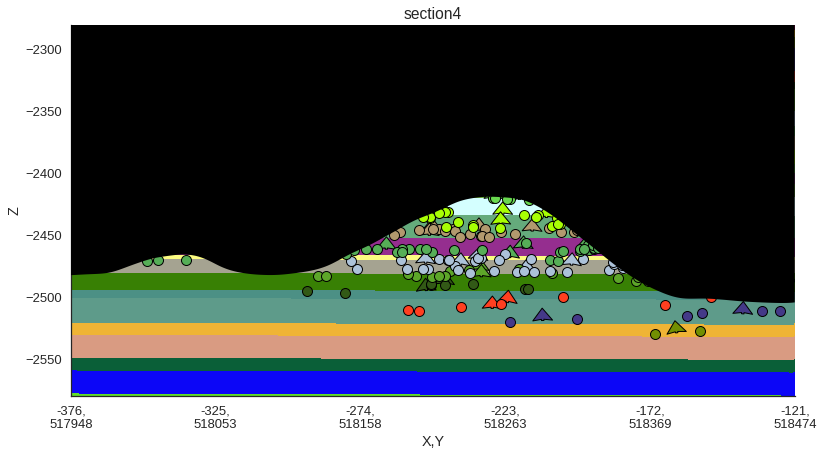

In [28]:
gp.plot.plot_section_by_name(geo_model, 'section4', show_topo=True, show_all_data=True)

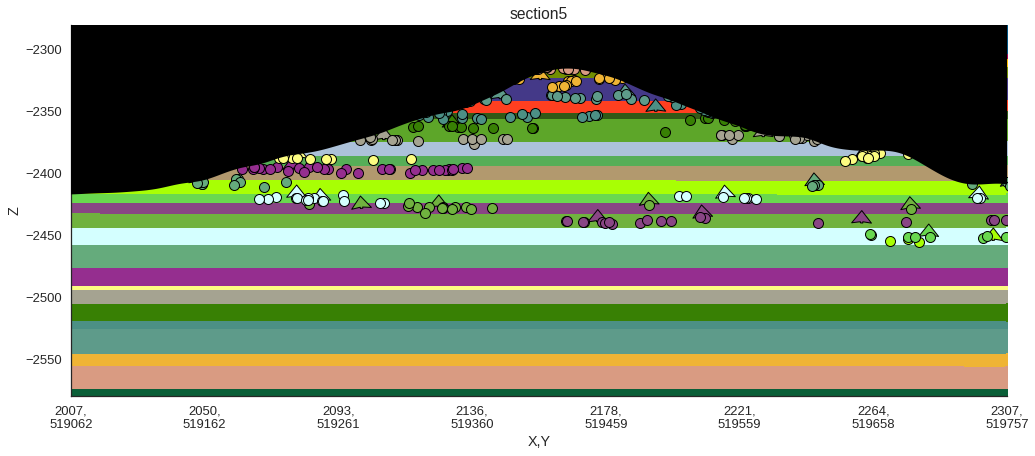

In [29]:
gp.plot.plot_section_by_name(geo_model, 'section5', show_topo=True, show_all_data=True)

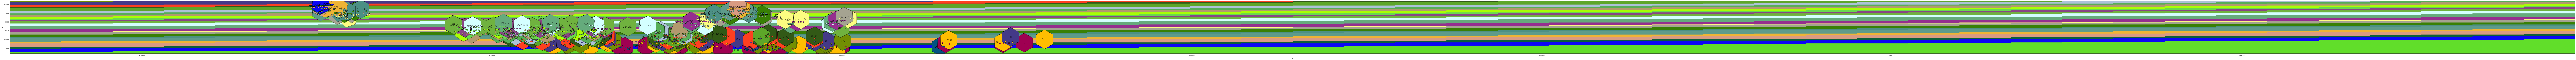

In [30]:
gp.plot.plot_section(geo_model, direction='x',show_all_data=True);

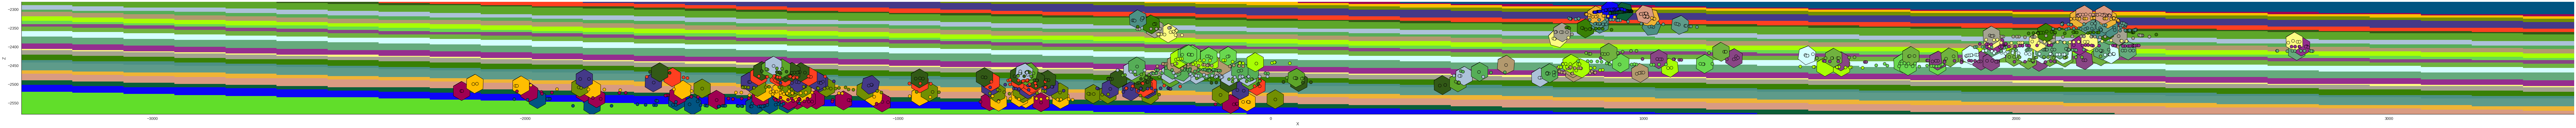

In [31]:
gp.plot.plot_section(geo_model, direction='y',show_all_data=True)

30825.038208007812


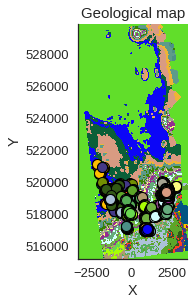

In [32]:
gp.plot.plot_map(geo_model, contour_lines=True, show_data=True, figsize=(24,24))

In [33]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,Surface 1.0,Default series,1,False,#015482,1
1,Surface 2.0,Default series,2,False,#9f0052,2
2,Surface 3.0,Default series,3,False,#ffbe00,3
3,Surface 4.0,Default series,4,False,#728f02,4
4,Surface 5.0,Default series,5,False,#443988,5
5,Surface 6.0,Default series,6,False,#ff3f20,6
6,Surface 7.0,Default series,7,False,#325916,7
7,Surface 8.0,Default series,8,False,#5DA629,8
8,Surface 9.0,Default series,9,False,#acc2d9,9
9,Surface 10.0,Default series,10,False,#56ae57,10


# Export

In [55]:
!mkdir ./sera_gempy_eros_jan1

mkdir: cannot create directory ‘./sera_gempy_eros_jan1’: File exists


In [56]:
gp.plot.export_to_vtk(geo_model, "./sera_gempy_eros_jan1/sera", 
                      name='sera_gempy_eros_jan1', voxels=True, surfaces=True)

True

In [57]:
surfaces = sorted(list(Path('./sera_gempy_eros_jan1/').glob('sera_s*')), key = lambda f: int(f.stem.split('_')[-1]))
surfaces

[PosixPath('sera_gempy_eros_jan1/sera_surfaces_0.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_1.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_2.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_3.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_4.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_5.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_6.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_7.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_8.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_9.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_10.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_11.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_12.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_13.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_14.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_15.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_surfaces_16.vtp'),
 PosixPath('sera_gempy_eros_jan1/sera_sur

In [58]:
planes_pv = pv.MultiBlock()
for i, v in enumerate(surfaces,start=0):
    surface = pv.read(v)
    surface['layer_id'] = np.repeat(i+1, surface.n_points)
    planes_pv[f'layer_{i+1}'] = surface

In [59]:
planes_pv.save('./sera_gempy_eros_jan1_combo.vtmb')

# uncertainty analysis

1. try to get the residuals on the surface points only


In [41]:
sol =lith

In [42]:
geo_model.grid.active_grids

array([ True, False,  True,  True, False])

In [43]:
geo_model.interpolator

In [44]:
lith.scalar_field_at_surface_points

array([[0.96248076, 0.96616787, 0.96820874, 0.97187714, 0.97382749,
        0.9778153 , 0.97913626, 0.98185259, 0.98406858, 0.98476814,
        0.98761825, 0.99133599, 0.99405259, 0.99632045, 0.9980238 ,
        0.99943725, 1.00167365, 1.0039426 , 1.00558771, 1.00783495,
        1.01152835, 1.01250151, 1.01447868, 1.01807805, 1.01976199,
        1.02104825, 1.0217376 ]])

In [45]:
lith.values_at_surface_points

array([], shape=(0, 2646), dtype=float64)

In [46]:
lith.values_matrix

array([], shape=(0, 250000), dtype=float64)

from leguark
hey Andrew, I answer you here that is more handy. Finding outliers in a clever way is something we have been thinking ourselves. We had some ideas as using the automatic differentiation capabilities of gempy to compute the gradient with respect the conditional number of the covariance matrix.
Something easier that you may try which is very similar to hat you do with OLS is to check the scalar field value at each surface point. In principle all surfaces should have the same
those values I am not storing them in the Solutions class but you can access to them by setting the arg set_solutions=False in gp.compute_model
if you do so, you will get all the arrays that theano returns
## I think that is the third element is the values of the scalar field for each series
## and in the axis 0 is all the values of the grid + the surface_points (at the end of the array, just check the shape)

In [50]:
expected_norientations = geo_model.interpolator.orientations.df.shape[0]
expected_norientations

231

In [51]:
expected_npoints = geo_model.interpolator.surface_points.df.shape[0]
expected_npoints

1350

# Okay so the shapes do not at all match up with what I would expect

let's try just computing a custom grid at my surface values?

In [52]:
points = np.array(geo_model.surface_points.df[['X', 'Y', 'Z']])#[0:10]
expected_s = np.array(geo_model.surface_points.df['id'])#[0:10]
points.shape, expected_s.shape


((1350, 3), (1350,))

In [53]:
tsol = gp.compute_model_at(new_grid=points, model=geo_model,output='geology')

Active grids: ['custom']


In [60]:
for i,x in enumerate(tsol):
    print(f'{i} shape: {x.shape}')

0 shape: (1, 3996)
1 shape: (1, 1, 3996)
2 shape: (2019,)
3 shape: (1, 3996)
4 shape: (1, 27)
5 shape: (1, 3996)


In [62]:
expected_s[0:1000]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

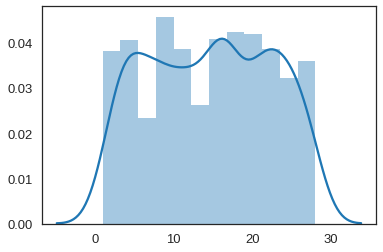

In [84]:
sn.distplot(tsol[0][0,:points.shape[0]])

In [100]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,Surface 1.0,Default series,1,False,#015482,1
1,Surface 2.0,Default series,2,False,#9f0052,2
2,Surface 3.0,Default series,3,False,#ffbe00,3
3,Surface 4.0,Default series,4,False,#728f02,4
4,Surface 5.0,Default series,5,False,#443988,5
5,Surface 6.0,Default series,6,False,#ff3f20,6
6,Surface 7.0,Default series,7,False,#325916,7
7,Surface 8.0,Default series,8,False,#5DA629,8
8,Surface 9.0,Default series,9,False,#acc2d9,9
9,Surface 10.0,Default series,10,False,#56ae57,10


In [101]:
geo_model.surfaces.df.shape

(28, 8)

In [85]:
pd.Series(tsol[0][0,:points.shape[0]]).describe()

count    1350.000000
mean       14.611654
std         7.761190
min         1.000000
25%         8.000000
50%        15.000000
75%        21.000000
max        28.000000
dtype: float64

## looks like the basement is being included in the scalar field, so my data ranges from 2 to 28? aghhh 1 indexing

In [102]:
np.abs(tsol[0][0,:points.shape[0]] -28) - expected_s

array([-1.00000000e+00, -5.00000000e-01, -1.00000000e+00, ...,
       -6.05619022e-09, -9.92926985e-09, -2.81932238e-08])

In [103]:
resid = pd.DataFrame({'resid': np.abs(tsol[0][0,:points.shape[0]] -29) - expected_s, 'exp': expected_s})

In [104]:
resid

,resid,exp
0,0.000000,1
1,0.500000,1
2,0.000000,1
3,0.000000,1
4,0.000000,1
...,...,...
1345,0.999822,27
1346,0.985618,27
1347,1.000000,27
1348,1.000000,27


In [105]:
import seaborn as sn

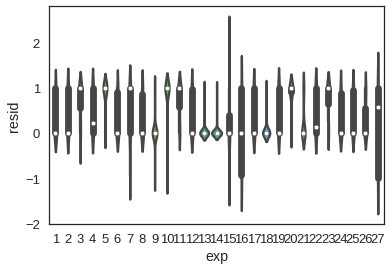

In [106]:
sn.violinplot(x='exp', y='resid', data=resid)

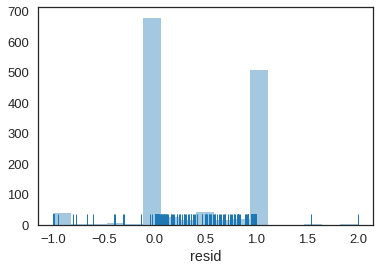

In [107]:
sn.distplot(resid.resid, kde=False,rug=True, norm_hist=False, )

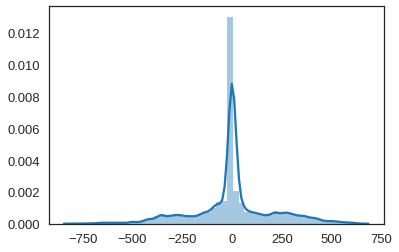

In [109]:
sn.distplot(tsol[2])

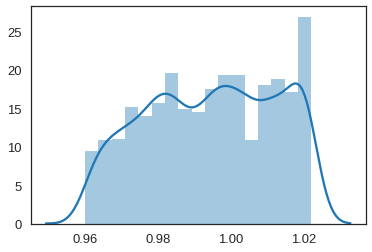

In [110]:
sn.distplot(tsol[3])

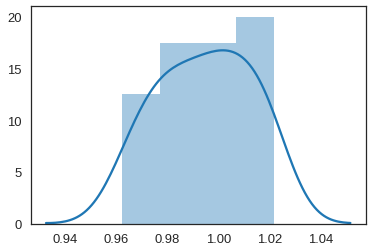

In [111]:
sn.distplot(tsol[4])

In [112]:
geo_model.surface_points.df[['X', 'Y', 'Z','id']]

,X,Y,Z,id
0,-1394.836844,519457.690560,-2559.139404,1
1,-1350.614292,519603.658037,-2555.291016,1
2,-1372.164888,519491.965456,-2559.155029,1
3,-1430.681935,519374.796357,-2557.687012,1
4,-1361.766417,519577.498856,-2558.577393,1
...,...,...,...,...
1345,928.500000,517034.500000,-2299.622559,27
1346,913.500000,517011.500000,-2299.989258,27
1347,940.000000,517065.500000,-2298.584473,27
1348,931.000000,517044.000000,-2298.619629,27


In [113]:
tsol[0]

array([[28.        , 27.5       , 28.        , ...,  1.00000044,
         1.00000044,  1.00000044]])

In [114]:
_ = geo_model.interpolator.get_python_input_block(append_control=True, fault_drift=None)
for i,x in enumerate(_):
    print(f'{i} shape: {x.shape}')
print(_[6])

0 shape: (231, 3)
1 shape: (231,)
2 shape: (231,)
3 shape: (231,)
4 shape: (1350, 3)
5 shape: (0, 3996)
6 shape: (1350, 3)
7 shape: (1, 28)
8 shape: (1000,)
9 shape: (1000,)
10 shape: (1000,)
[[0.32829019 0.53974658 0.48699057]
 [0.3327427  0.5544432  0.48737805]
 [0.3305729  0.54319752 0.486989  ]
 ...
 [0.56337145 0.2988907  0.51322435]
 [0.56246529 0.29672599 0.51322081]
 [0.56357282 0.29969618 0.5132097 ]]


In [166]:
geo_model.interpolator.additional_data\
.structure_data.df.loc['values', 'len series surface_points']

array([492,   0])

In [168]:
geo_model.interpolator.additional_data\
.structure_data.df.loc['values', 'number surfaces per series']

array([27,  0])

In [164]:
print(geo_model.interpolator.len_series_i)
print(geo_model.interpolator.len_series_o)
print(geo_model.interpolator.len_series_u)
print(geo_model.interpolator.len_series_f)
print(geo_model.interpolator.len_series_w)

[465]
[157]
[3]
[0]
[939]


## from source: self.len_series_w = self.len_series_i + self.len_series_o * 3 + self.len_series_u + self.len_series_f

In [169]:
for i,x in enumerate(tsol):
    print(f'{i} shape: {x.shape}')

0 shape: (1, 1422)
1 shape: (1, 1, 1422)
2 shape: (939,)
3 shape: (1, 1422)
4 shape: (1, 27)
5 shape: (1, 1422)


In [170]:
geo_model.interpolator.print_theano_shared()

len sereies i [  0 465]
len sereies o [  0 157]
len sereies w [  0 939]
n surfaces per series [ 0 27 27]
n universal eq [3 3]
is finite [0 0]
is erosion [0]
is onlap [0]


In [187]:
geo_model.grid.values.shape[0]

492

In [189]:
2* 465 + 492 

1422

# okay so the 930 is 2x the len of series i described above 

In [115]:
geo_model.interpolator.theano_graph.c_o_T.get_value()

array(1.00684234e-06)

In [116]:
geo_model.interpolator.theano_graph.number_of_points_per_surface_T.get_value()

array([49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49, 49, 49], dtype=int32)

In [117]:
geo_model.interpolator.theano_graph.weights_vector.get_value().shape

(2019,)

In [118]:
geo_model.interpolator.theano_graph.scalar_fields_matrix.get_value().shape

(1, 3996)

In [119]:
geo_model.solutions.scalar_field_matrix

array([[0.95475684, 0.95534321, 0.95592958, ..., 1.01737208, 1.01795837,
        1.01854466]])

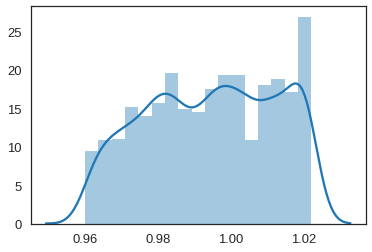

In [120]:
sn.distplot(geo_model.interpolator.theano_graph.scalar_fields_matrix.get_value())

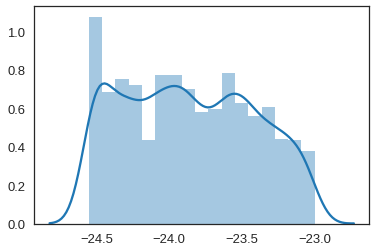

In [121]:
sn.distplot(1-geo_model.interpolator.theano_graph.scalar_fields_matrix.get_value()*25)